In [1]:
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
concrete_txt = np.genfromtxt("../data/concrete.csv", delimiter=" ,")

In [22]:
concrete = data.Data(concrete_txt[:,:-1], concrete_txt[:,-1],              
                     target_names = ["Cement", "Slag", "Fly Ash", "Water", "Superplasticiser", "Coarse Agg", "Fine Agg", "Age"],
                      label_names = ["Strength"],
                     label_sigma = 0,
                    test_size = 0.1)

In [23]:
len(concrete.labels)

932

KeyboardInterrupt: 

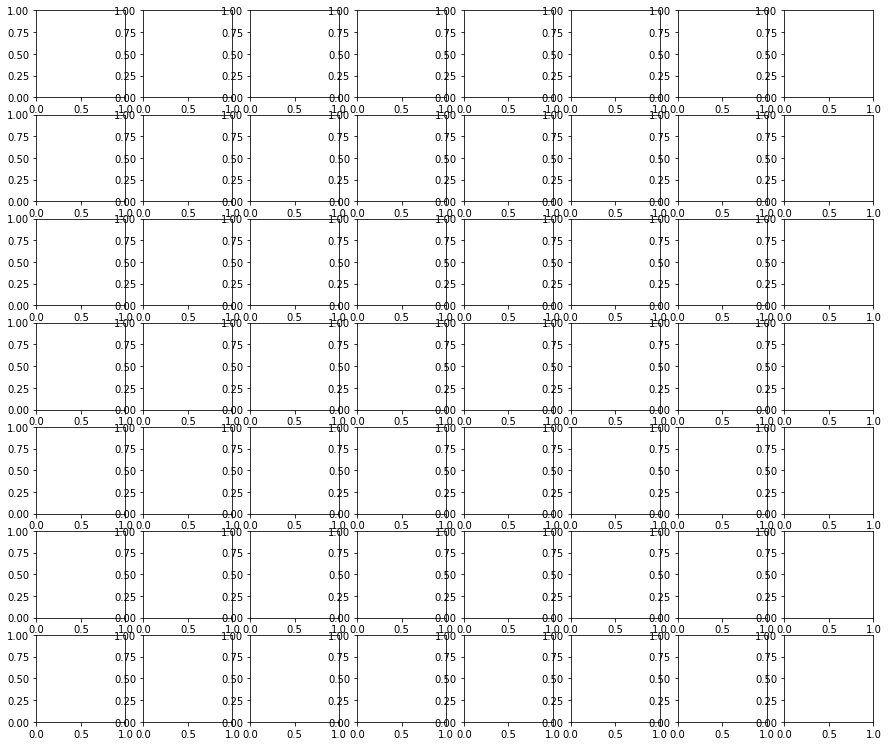

In [24]:
from heron import corner
corner.corner(concrete, figsize=(15,15))

In [25]:
from heron import regression
from heron import kernels

In [26]:
gp = regression.Regressor(concrete, kernel=kernels.SquaredExponential(ndim=8), )

In [27]:
concrete.labels.shape

(932,)

In [28]:
new_point = np.atleast_2d([0.1]*8)

In [29]:
new_point = np.atleast_2d(gp.training_data[1])
new_point[0,1]+=0.1

In [31]:
gp.prediction(new_point)

(array([ 2.33]), array([[ 802702.33]]))

In [37]:
gp.set_hyperparameters([.1]*9)

-4380228.7933512274

In [38]:
gp.grad_loglikelihood()

array([  7.45382525e+11,   4.00807308e+09,   5.97385091e+08,
         1.75097910e+08,   1.37628707e+09,   3.17700150e+09,
         3.01416230e+08,   2.74505932e+09,   3.26274746e+10])

In [39]:
from scipy.optimize import minimize

In [116]:
def nll(p):
    #p[0] = 1
    #if np.any()
    gp.set_hyperparameters(p)
    ll = gp.loglikelihood()
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    #p[0] = 1
    gp.set_hyperparameters(p)
    return -gp.grad_loglikelihood()

In [128]:
x0 = [0.9]*9
#x0[0] = np.std(gp.training_y)**.5
res = minimize(nll, x0, method='BFGS', jac=grad_nll ,options={'disp': True})

         Current function value: 224005.827092
         Iterations: 1
         Function evaluations: 83
         Gradient evaluations: 71


In [121]:
np.std(gp.training_y)**2

0.044285646567463172

In [130]:
gp.kernel.flat_hyper

array([ 1.53868334,  1.16019096,  1.15398001,  1.1563716 ,  1.15970929,
        1.1610711 ,  1.16055234,  1.15944417,  1.27876526])

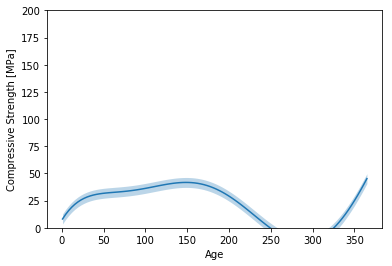

In [138]:
i = -1
test_point = -1
new_point = np.atleast_2d(concrete.denormalise(concrete.test_targets[test_point], "target"))
new_point = np.tile(new_point, (100,1))
new_point[:,i] = (np.linspace(0,1,100))*concrete.normaliser['target'][1][i] + concrete.normaliser['target'][0][i]
pred = gp.prediction(new_point)
x = new_point[:,i]
plt.plot(x, pred[0])
plt.ylim([0,200])
#plt.xlim([0,gp.training_object.targets_scale[1][i]])
plt.xlabel(gp.training_object.target_names[i])
#plt.xlabel(r"Superplasticiser [kg / m$^3$]")
plt.ylabel("Compressive Strength [MPa]")
err = np.diag(pred[1])
#err = gp.training_object.denormalise(err,"label")
err = err* 1.96
plt.fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
#plt.plot(gp.training_object.denormalise(concrete.test_targets[test_point], "target")[i], 
#        gp.training_object.denormalise(concrete.test_labels, "label")[test_point], '.')
#plt.savefig('superplasticiser.png', dpi=300)